In [20]:
import pandas as pd
import geopandas as gpd
import json
import numpy as np
import datetime
import plotly
import os
from plotly import graph_objects as go
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

%load_ext autoreload

from scripts.charts import plot_line, plot_bar, plot_peak, print_charts_country
from scripts.features import add_variables_covid, add_variables_apple, join_series_day_since, join_series_date

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [670]:
df_orig = pd.read_csv("data-processed/rki-reports.csv")
df_apple = pd.read_csv("data-processed/data_apple_prepared.csv")
df_rki_orig = pd.read_csv('dash/data/data_rki_apple_prepared_dash.csv')
df_jh_world = pd.read_csv('dash/data/data_jhu_world.csv')
# df = pd.read_csv("dash/data/data_rki_apple_prepared_dash.csv")
df_rki_orig['date']=df_rki_orig['date'].astype('datetime64[ns]')
df_rki_orig.index = df_rki_orig.date
df_jh_world['date']=df_jh_world['date'].astype('datetime64[ns]')
df_jh_world.index = df_jh_world.date

In [672]:
df_orig.loc[df_orig.date == '2020-05-28'] #.to_csv("data-processed/rki-reports.csv", index=False)

,land,date,driving,walking,transit,confirmed,dead,iso_code,confirmed_change,confirmed_active_cases,confirmed_active_cases_change,confirmed_peak_date,population_100k,confirmed_per_100k,confirmed_change_per_100k,confirmed_active_cases_per_100k,dead_change,dead_doubling_days,lethality,dead_per_100k,dead_change_per_100k
0,Thuringia,2020-05-28,NaN,NaN,NaN,2932,158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Lower Saxony,2020-05-28,NaN,NaN,NaN,11750,583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Baden-Wuerttemberg,2020-05-28,NaN,NaN,NaN,34129,1724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bavaria,2020-05-28,NaN,NaN,NaN,46729,2438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Berlin,2020-05-28,NaN,NaN,NaN,6703,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Brandenburg,2020-05-28,NaN,NaN,NaN,3261,155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Bremen,2020-05-28,NaN,NaN,NaN,1348,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Hamburg,2020-05-28,NaN,NaN,NaN,5076,245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Mecklenburg-Western Pomerania,2020-05-28,NaN,NaN,NaN,760,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Hesse,2020-05-28,NaN,NaN,NaN,9915,471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [194]:
df_orig.columns

Index(['date_index', 'date', 'land', 'confirmed', 'dead', 'name', 'iso_code',
       'capital', 'area', 'population', 'confirmed_avg3', 'confirmed_change',
       'confirmed_change_avg3', 'confirmed_change_3w', 'confirmed_change_pct',
       'confirmed_change_pct_avg3', 'confirmed_change_pct_3w',
       'confirmed_doubling_days', 'confirmed_doubling_days_3w',
       'confirmed_doubling_days_avg3', 'confirmed_doubling_days_3w_avg3',
       'confirmed_active_cases', 'confirmed_active_cases_change',
       'confirmed_peak_log', 'confirmed_peak_date', 'confirmed_day_since_10',
       'population_100k', 'confirmed_per_100k', 'confirmed_change_per_100k',
       'confirmed_active_cases_per_100k',
       'confirmed_active_cases_change_per_100k', 'dead_avg3', 'dead_change',
       'dead_change_avg3', 'dead_change_3w', 'dead_change_pct',
       'dead_change_pct_avg3', 'dead_change_pct_3w', 'dead_doubling_days',
       'dead_doubling_days_3w', 'dead_doubling_days_avg3',
       'dead_doubling_days

In [3]:
l = 'Bremen'
column = 'confirmed'
peak_index = df.loc[(df.land == l) & (df['confirmed_peak_date'] == -1), column].index.tolist()
df.loc[(df.index.isin(peak_index)) & (df.land == l), column]

date
2020-03-04      3
2020-04-19    585
Name: confirmed, dtype: int64

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

def findpeak_trend(df):
    df_peak_log = df.loc[:, ['confirmed_peak_log']].dropna()
    
    days_pred_start = 10  # for how long to draw  the trend
    days_since_first_peak_start = 7  # how many days to wait since the first outbreak before estimating trend
    days_other_peak_starts = 7  # how many days since the second+ outbreak should pass before calculating trend

    # is we do not have enough data then exit
    if len(df_peak_log) < days_since_first_peak_start:
        df['peak_log_trend'] = np.NaN
        return df
    # find all indixes of outbreak beginnings
    peak_indixes = df.loc[df.confirmed_peak_date == -1].index.tolist()
    peak_indixes[0] = df_peak_log.index.min()
    
    # iterate over peak indixes
    for i, index in enumerate(peak_indixes):
        peak_index = peak_indixes[i]
        days_pred = days_pred_start
        if i == 0:
            # select y values since the beginning of the outbreak till defined number of days
            # and take a 3 days moving average for a smother trend
            days_add = days_since_first_peak_start
            
            # If we have two peak starts then the range we take to estmate the first should not be longer than the distance between 1st and 2nd
#             if len(peak_indixes) > 1:
#                 if days_add < len(df.loc[peak_index:peak_indixes[i+1]]):
#                     days_add = len(df.loc[peak_index:peak_indixes[i+1]])
#             else:
#                 # Else take all the days we have
#                 if days_add < len(df):
#                     days_add = len(df)
                    
            y = df_peak_log.loc[df_peak_log.index < peak_index +
                       datetime.timedelta(days=days_add), 'confirmed_peak_log'] #.rolling(3).median().dropna()
        else:
            # for the second+ outbreak use different number of minimum required days
            days_add = days_other_peak_starts
            # exis if we do not have enough data for an estimation
            if len(df.loc[peak_index:peak_index + datetime.timedelta(days=days_add)]) < days_other_peak_starts:
                return df
            else:
                # if we have more data to estimate second peak then use all of it
                days_other_peak_starts = len(df.loc[peak_index:df.index.max()])
                # if enough data then select y for estimating the trend
                y = df_peak_log.loc[(df_peak_log.index < df_peak_log.index.max()) &
                           (df_peak_log.index > peak_index), 'confirmed_peak_log'] #.rolling(3).median().dropna()

        # calculate X as number of days in Y and reshape to fit in LogReg model
        X = (y.index - y.index[0]).days.values.reshape(-1, 1)
    
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        X = scaler.fit_transform(X)
        
        # train LogReg model
        reg = LinearRegression().fit(X, y)

        # predict/estimate trend for 10, 20 and 30, 35 days forward, exit if the trend crosses 0
        for days in [days_pred_start + i for i in [0, 10, 20, 35]]:
            X2 = (range(1, days + len(y)) + max(X)[0]).reshape(-1, 1)
            X2 = scaler.transform(X2)
            trend = reg.predict(X2)
            days_pred = days
            if min(trend) < 0:
                break
        
        

        # prepare y2 dataframe using index as a date range between the last date of y+1
        # and last date of y+days_estimated_for
        y2_index = pd.date_range(y.index.min() + datetime.timedelta(days=1),
                                 y.index.max() + datetime.timedelta(days=days_pred))
        y2 = pd.DataFrame(index=y2_index, data=trend, columns=['peak_log_trend'])
        
        # remove extra negative values (if exist) except the first one (for clarity)
        try:
            first_negative_val = y2.loc[y2.peak_log_trend < 0].index[0]
            y2 = y2.loc[y2.index <= first_negative_val, 'peak_log_trend']
        except:
            pass
        # in case its the first peak simply merge DFs
        if i == 0:
            df = df.join(y2, how='outer')
        # otherwise merge and make sure that we fit all trends in the same column for easy plotting
        else:
            df = pd.merge(df, y2, left_index=True, right_index=True, how='outer', suffixes=('_x', '_y'))
            df['peak_log_trend'] = df.loc[:, ['peak_log_trend_x', 'peak_log_trend_y']].apply(
                lambda row: row[0] if pd.isnull(row[0]) == False else row[1], axis=1)
            df.drop(['peak_log_trend_x', 'peak_log_trend_y'], axis=1, inplace=True)

    return df

In [54]:
def add_trend_linear(df, column, date_range, days_add=15):
    y = df.loc[(df.index >= date_range[0]) & (df.index <= date_range[1]), column].dropna() #.rolling(3).median().dropna()

    # calculate X as number of days in Y and reshape to fit in LogReg model
    X = (y.index - y.index[0]).days.values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)

    # train LogReg model
    reg = LinearRegression().fit(X, y)

    # predict/estimate trend for 10, 20 and 30, 35 days forward, exit if the trend crosses 0
    X2 = (range(1, days_add + len(y)) + max(X)[0]).reshape(-1, 1)
    X2 = scaler.transform(X2)
    trend = reg.predict(X2)
    # prepare y2 dataframe using index as a date range between the last date of y+1
    # and last date of y+days_estimated_for
    y2_index = pd.date_range(y.index.min() + datetime.timedelta(days=1),
                             y.index.max() + datetime.timedelta(days=days_add))
    y2 = pd.DataFrame(index=y2_index, data=trend, columns=[f'{column}_trend'])
    df = df.join(y2, how='outer')
    return df

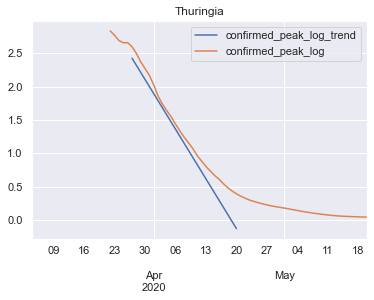

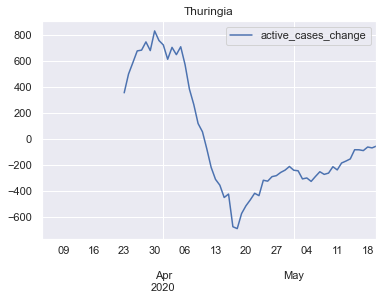

In [50]:
df_ham = df.loc[(df.land == 'Baden-Wuerttemberg')].copy()
df_ham.drop('peak_log_trend', axis=1, inplace=True)
dd = add_trend_linear(df_ham, 'confirmed_peak_log', ['2020-03-20', '2020-04-05'])
dd['active_cases_change'] = dd['confirmed_active_cases'] - dd['confirmed_active_cases'].shift(1)
dd.loc[:, ['confirmed_peak_log_trend', 'confirmed_peak_log']].rolling(7).mean().plot(title=l)
dd.loc[:, ['active_cases_change']].rolling(7).mean().plot(title=l)

In [48]:
df.land.unique()

array(['Baden-Wuerttemberg', 'Bavaria', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hesse', 'Lower Saxony',
       'Mecklenburg-Western Pomerania', 'North Rhine-Westphalia',
       'Rhineland-Palatinate', 'Saarland', 'Saxony', 'Saxony-Anhalt',
       'Schleswig-Holstein', 'Thuringia'], dtype=object)

In [195]:
# for l in df.land.unique():
#     df_ham = df.loc[df.land == l].copy()
#     df_ham.drop('peak_log_trend', axis=1, inplace=True)
#     dd = findpeak_trend(df_ham)
#     dd['active_cases_change'] = dd['confirmed_active_cases'] - dd['confirmed_active_cases'].shift(1)
#     dd.loc[:, ['peak_log_trend', 'confirmed_peak_log']].rolling(7).mean().plot(title=l)
#     dd.loc[:, ['active_cases_change', 'confirmed_change']].rolling(7).mean().plot(title=l)
#     dd.loc[:, ['confirmed_active_cases']].rolling(7).mean().plot(title=l)

In [196]:
# import matplotlib.pyplot as plt
# plt.close('all')

In [8]:
from fbprophet import Prophet
import datetime
import pandas as pd


def add_forecast_prophet(df_in, column, window=60, ):
    df = df_in.loc[:, [column]].dropna()
    df['ds'] = df.index
    df.columns = ['y', 'ds']
    m = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
    m.fit(df)
    future = m.make_future_dataframe(periods=window)
    forecast = m.predict(future)
    forecast.set_index(forecast.ds, inplace=True)
    forecast = forecast.loc[:, ['yhat', 'yhat_lower', 'yhat_upper']]
    df_extra_dates = pd.DataFrame(
        {'day': pd.Series([max(df_in.index) + datetime.timedelta(1), max(df_in.index) + datetime.timedelta(window)])})
    df_extra_dates.set_index('day', inplace=True)
    df_extra_dates = df_extra_dates.asfreq('D')
    df_in = df_in.append(df_extra_dates)
    df_result = pd.concat([df_in, forecast], axis=1)
    df_result[f'peak_log_trend'] = df_result.loc[df_result[column].isnull() == True, ['yhat']]

    return df_result


In [ ]:
# dd2 = add_forecast_prophet(df_ham, 'confirmed_peak_log')

In [ ]:
# dd2

In [ ]:
# dd2.loc[:, ['peak_log_trend', 'confirmed_peak_log']].plot()

In [116]:
import warnings
warnings.filterwarnings("ignore")
def add_trend_arima(df, column, date_range,  days_add=15, start=None):
    if start == None:
        start = df.index.max().date()
    y = df.loc[(df.index >= date_range[0]) & (df.index <= date_range[1]), column].dropna() #.rolling(3).median().dropna()

    # calculate X as number of days in Y and reshape to fit in LogReg model
    X = (y.index - y.index[0]).days.values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)

    # train LogReg model
    import statsmodels.api as sm
    mod = sm.tsa.statespace.SARIMAX(y,
#                                     order=(0, 0, 0),
#                                     seasonal_order=(0,0,0,0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    
    pred_dynamic = results.get_prediction(start=pd.to_datetime(start), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y2 = pred_dynamic.predicted_mean
    y2.rename(f'{column}_trend', inplace=True)
    y2.columns = [f'{column}_trend']
    
    # Get forecast 500 steps ahead in future
    pred_uc = results.get_forecast(steps=days_add)
    pred_uc = pred_uc.predicted_mean
    pred_uc.rename(f'{column}_trend', inplace=True)
    pred_uc.columns = [f'{column}_trend']
    
#     print(y2,"\n")
#     print(pred_uc,"\n")
    
    print(results.summary().tables[1])
#     results.plot_diagnostics(figsize=(15, 12))
#     plt.show()

    df = df.join(y2, how='outer')
    df = pd.merge(df, pred_uc, left_index=True, right_index=True, how='outer', suffixes=('_x', '_y'))
    df[f'{column}_trend'] = df.loc[:, [f'{column}_trend_x', f'{column}_trend_y']].apply(
            lambda row: row[0] if pd.isnull(row[0]) == False else row[1], axis=1)
    df.drop([f'{column}_trend_x', f'{column}_trend_y'], axis=1, inplace=True)

    return df


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9633      0.017     55.800      0.000       0.929       0.997
sigma2         0.0214      0.011      1.939      0.052      -0.000       0.043


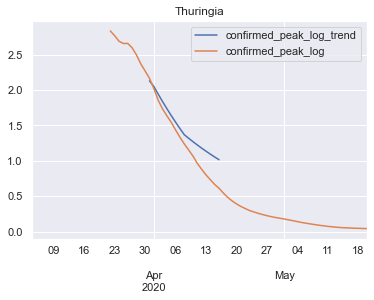

In [117]:
df_ham = df.loc[(df.land == 'Baden-Wuerttemberg')].copy()
df_ham.drop('peak_log_trend', axis=1, inplace=True)
dd = add_trend_arima(df_ham, 'confirmed_peak_log', ['2020-03-04', '2020-04-01'], start='2020-03-25')
dd.loc[:, ['confirmed_peak_log_trend', 'confirmed_peak_log']].rolling(7).mean().plot(title=l)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5376      0.103      5.233      0.000       0.336       0.739
sigma2      9343.6318    875.467     10.673      0.000    7627.747    1.11e+04


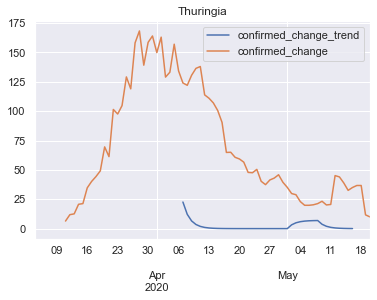

In [122]:
land = 'Hamburg'
column = 'confirmed_change'
df_ham = df.loc[(df.land == land)].copy()
# df_ham.drop('peak_log_trend', axis=1, inplace=True)
dd = add_trend_arima(df_ham, column, ['2020-03-04', '2020-05-01'], start='2020-04-01')
dd.loc[:, [f'{column}_trend', column]].rolling(7).mean().plot(title=l)

In [162]:
df_jh_world.columns

Index(['state', 'land', 'lat', 'lng', 'iso_code', 'date', 'confirmed',
       'confirmed_avg3', 'confirmed_change', 'confirmed_change_avg3',
       'confirmed_change_3w', 'confirmed_change_pct',
       'confirmed_change_pct_avg3', 'confirmed_change_pct_3w',
       'confirmed_doubling_days', 'confirmed_doubling_days_3w',
       'confirmed_doubling_days_avg3', 'confirmed_doubling_days_3w_avg3',
       'confirmed_active_cases', 'confirmed_active_cases_change',
       'confirmed_peak_log', 'confirmed_peak_date', 'confirmed_day_since_10',
       'population_100k', 'confirmed_per_100k', 'confirmed_change_per_100k',
       'confirmed_active_cases_per_100k',
       'confirmed_active_cases_change_per_100k', 'dead', 'dead_avg3',
       'dead_change', 'dead_change_avg3', 'dead_change_3w', 'dead_change_pct',
       'dead_change_pct_avg3', 'dead_change_pct_3w', 'dead_doubling_days',
       'dead_doubling_days_3w', 'dead_doubling_days_avg3',
       'dead_doubling_days_3w_avg3', 'dead_day_since_10', 

In [161]:
# sorted(df_jh_world.round(3)['confirmed_change_per_100k'], reverse=True)

In [143]:
df_rki_orig['date'] = df_rki_orig['date'].astype('datetime64[ns]')

In [141]:
selected_colum = 'confirmed'

ro = df_rki_orig.groupby('land').rolling(7, on='date').mean().reset_index(drop=False).loc[:,
         ['date', 'land', selected_colum]]
df = df_rki_orig.merge(ro, on=['date', 'land'], suffixes=('', '_weekly')).round(3)

In [200]:
df_apple.head(1)

,date_index,geo_type,region,alternative_name,sub-region,country,date,driving,transit,walking
0,2020-01-13,city,Aachen,NaN,North Rhine-Westphalia,Germany,2020-01-13,100.0,NaN,100.0


In [201]:
df_jh_world.head(1)

,land,iso_code,date,confirmed,confirmed_change,confirmed_change_pct_3w,confirmed_doubling_days_3w_avg3,confirmed_active_cases,confirmed_active_cases_change,confirmed_peak_date,population_100k,confirmed_per_100k,confirmed_change_per_100k,confirmed_active_cases_per_100k,dead,dead_change,dead_doubling_days,lethality,dead_per_100k,dead_change_per_100k,region_wb
date,,,,,,,,,,,,,,,,,,,,,
2020-02-24,Afghanistan,AFG,2020-02-24,1.0,NaN,NaN,NaN,NaN,NaN,-1,371.72,0.00269,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,South Asia


In [203]:
len(df_jh_world.land.unique())

186

In [204]:
len(df_apple.country.unique())

48

In [220]:
df_apple['country'] = df_apple['country'].replace()

In [221]:
list(df_apple.loc[df_apple.country.isin(df_jh_world.land.unique()), 'country'].unique())

['Germany',
 'US',
 'Italy',
 'Australia',
 'Norway',
 'Mexico',
 'Japan',
 'Brazil',
 'Canada',
 'France',
 'Netherlands',
 'Spain',
 'Thailand',
 'Turkey',
 'Chile',
 'Belgium',
 'Greece',
 'New Zealand',
 'United Kingdom',
 'India',
 'Slovakia',
 'Hungary',
 'Switzerland',
 'Sweden',
 'Romania',
 'Argentina',
 'Austria',
 'Korea, South',
 'Egypt',
 'South Africa',
 'Denmark',
 'Morocco',
 'Czechia',
 'Israel',
 'Finland',
 'Taiwan*',
 'Ireland',
 'Indonesia',
 'Luxembourg',
 'United Arab Emirates',
 'Poland',
 'Vietnam',
 'Malaysia',
 'Russia',
 'Portugal',
 'Philippines',
 'Saudi Arabia']

In [222]:
list(df_apple.loc[~df_apple.country.isin(df_jh_world.land.unique()), 'country'].unique())

[nan]

In [ ]:
{'United States': 'US', 'Republic of Korea', 'Korea, South', 'Czech Republic': 'Czechia', 'Taiwan': 'Taiwan*'}

In [213]:
df_jh_world.loc[df_jh_world.land.str.contains('Taiwan')]

,land,iso_code,date,confirmed,confirmed_change,confirmed_change_pct_3w,confirmed_doubling_days_3w_avg3,confirmed_active_cases,confirmed_active_cases_change,confirmed_peak_date,population_100k,confirmed_per_100k,confirmed_change_per_100k,confirmed_active_cases_per_100k,dead,dead_change,dead_doubling_days,lethality,dead_per_100k,dead_change_per_100k,region_wb
date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,Taiwan*,TWN,2020-01-22,1.0,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,East Asia & Pacific
2020-01-23,Taiwan*,TWN,2020-01-23,1.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,East Asia & Pacific
2020-01-24,Taiwan*,TWN,2020-01-24,3.0,2.0,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,East Asia & Pacific
2020-01-25,Taiwan*,TWN,2020-01-25,3.0,0.0,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,East Asia & Pacific
2020-01-26,Taiwan*,TWN,2020-01-26,4.0,1.0,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,East Asia & Pacific
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-20,Taiwan*,TWN,2020-05-20,440.0,0.0,0.00,100.0,0.0,0.0,0,NaN,NaN,NaN,NaN,7.0,0.0,100.0,0.0,NaN,NaN,East Asia & Pacific
2020-05-21,Taiwan*,TWN,2020-05-21,440.0,0.0,0.00,100.0,0.0,0.0,0,NaN,NaN,NaN,NaN,7.0,0.0,100.0,0.0,NaN,NaN,East Asia & Pacific
2020-05-22,Taiwan*,TWN,2020-05-22,441.0,1.0,9.09,75.0,1.0,1.0,0,NaN,NaN,NaN,NaN,7.0,0.0,100.0,0.0,NaN,NaN,East Asia & Pacific


In [239]:
df_orig = pd.read_csv("data-processed/rki-reports.csv")


In [240]:
# df_orig.loc[(df_orig.date == '2020-05-24')]

In [241]:
# df_orig.loc[(df_orig.date == '2020-05-24') & (df_orig.confirmed ==9762), 'land'] = 'Hesse'

In [ ]:
del 

In [262]:
# df_apple.loc[df_apple.geo_type]

In [264]:
# df_apple.geo_type.unique()

array(['city', 'county', 'sub-region', 'country/region'], dtype=object)

In [265]:
# df_apple.loc[(df_apple.country.isin(df_jh_world.land.unique()))
# #                   & (df_apple.geo_type == 'country/region')
#              , :].geo_type.unique()

This is the format of your plot grid:
⎡ (1,1)  ⎤  [ (1,2)  ]
⎣      : ⎦  [ (2,2)  ]



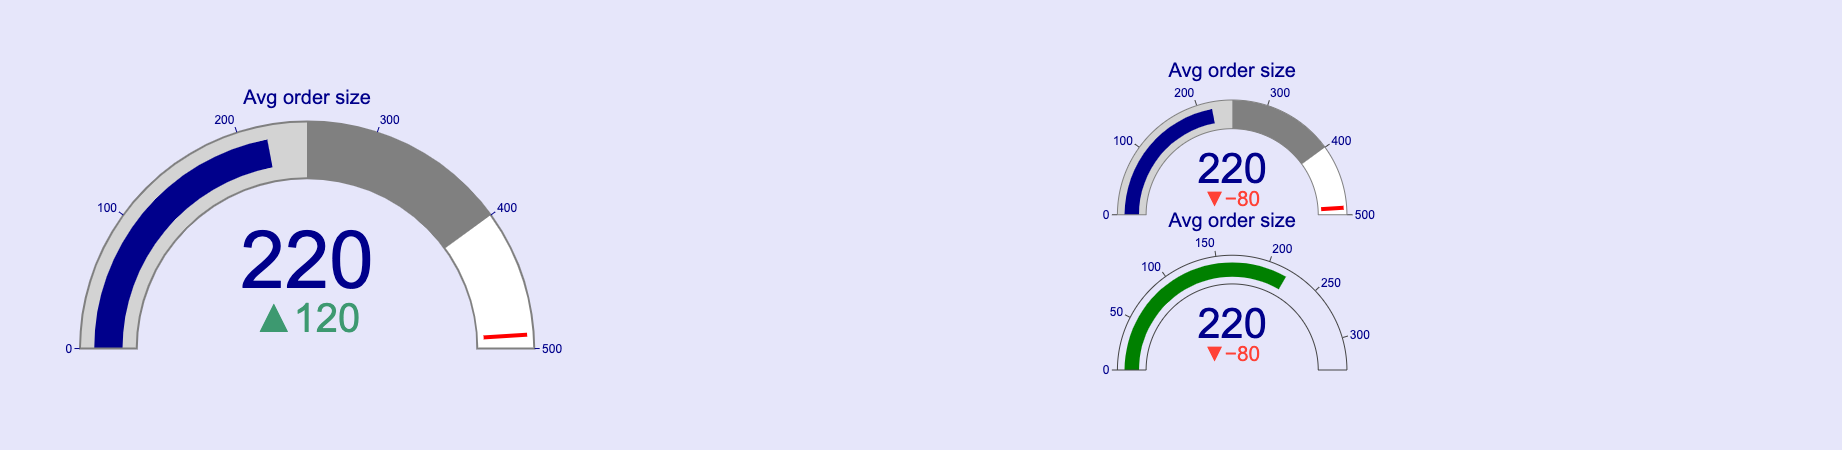

In [361]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(rows=2, cols=2, 
                    column_widths=[0.3, 0.7],
                    row_heights=[0.5, 0.5],
                    specs=[[{"type": 'indicator', "rowspan": 2}, {"type": 'indicator'}],
                                          [None, {"type": 'indicator'}]])
fig.print_grid()
fig.add_trace(go.Indicator(
    mode = "number+gauge+delta",
    gauge = {'axis': {'range': [None, 500], 'tickwidth': 1, 'tickcolor': "darkblue"},
             'bar': {'color': "darkblue"},
        'bgcolor': "white",
        'borderwidth': 2,
        'bordercolor': "gray",
             'steps' : [
                 {'range': [0, 250], 'color': "lightgray"},
                 {'range': [250, 400], 'color': "gray"}],
                  'threshold' : {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 490}},
    delta = {'reference': 100},
    value = 220,
    domain = {'x': [0, 1], 'y': [0.2, 0.9]},
    title = {'text': "Avg order size"}),
              row=1, col=1
             )


fig.add_trace(go.Indicator(
    mode = "number+gauge+delta",
    gauge = {'axis': {'range': [None, 500],},
             'bar': {'color': "darkblue"},
             'bgcolor': "white",
             'borderwidth': 1,
             'bordercolor': "gray",
             'steps' : [
                 {'range': [0, 250], 'color': "lightgray"},
                 {'range': [250, 400], 'color': "gray"}],
                  'threshold' : {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 490}},
    delta = {'reference': 300},
    value = 220,
    domain = {'x': [0, 1], 'y': [0.2, 0.9]},
    title = {'text': "Avg order size"}),
              row=1, col=2
             )

fig.add_trace(go.Indicator(
    mode = "number+gauge+delta",
#     gauge = {'shape': "bullet"},
    delta = {'reference': 300},
    value = 220,
    domain = {'x': [0, 1], 'y': [0.2, 0.9]},
    title = {'text': "Avg order size"}),
              row=2, col=2
             )
fig.update_layout(paper_bgcolor = "lavender", font = {'color': "darkblue", 'family': "Arial"})

fig.show()


In [344]:
column = 'confirmed_change'
reg_df_max = df_jh_world.reset_index(drop=True).groupby(['date', 'region_wb']).agg(['max'])[column].groupby('region_wb').max()
reg_df_max

,max
region_wb,
East Asia & Pacific,15133.0
Europe & Central Asia,11656.0
European Union,26843.0
Latin America & Caribbean,20803.0
Middle East & North Africa,3186.0
North America,36188.0
South Asia,7113.0
Sub-Saharan Africa,1240.0


In [359]:
reg_df_max.reset_index().loc[reg_df_max.index == 'European Union', 'max'].values[0]

26843.0

In [542]:
dd = df_jh_world.loc[df_jh_world.index == df_jh_world.index.max(), :].groupby('region_wb').agg(['sum'])['confirmed_change'].sort_values(by='sum',ascending=False).round(0)
dd

,sum
region_wb,
Latin America & Caribbean,30885.0
North America,21589.0
Europe & Central Asia,12802.0
South Asia,11522.0
Middle East & North Africa,9772.0
European Union,6030.0
Sub-Saharan Africa,3087.0
East Asia & Pacific,1433.0


In [543]:
6030.0 / 5026.18

1.199718275111516

In [640]:
df_jh_world.loc[df_jh_world.index == df_jh_world.index.max(), :].groupby(by=['land', 'region_wb']).agg(['max'])['population_100k'].groupby('region_wb').agg('sum') #.sort_values(by='sum',ascending=False).round(0)


,max
region_wb,
East Asia & Pacific,22766.00
Europe & Central Asia,4095.98
European Union,5026.18
Latin America & Caribbean,6375.80
Middle East & North Africa,4484.29
North America,3637.46
South Asia,18143.88
Sub-Saharan Africa,10748.51


In [644]:
df = df_jh_world
df.index = df.date
column = 'confirmed_change_per_100k'
column_original = column.replace('_per_100k', '')
reg_df_sum_population = df.groupby('region_wb').agg(['sum'])['population_100k']
reg_df_sum_population.columns = ['population']


reg_df_sum_total = df.groupby('region_wb').agg(['sum'])[column_original].sort_values(by='sum', ascending=False)

reg_df_max = df.reset_index(drop=True).groupby(['date', 'region_wb']).agg(['sum'])[column_original].groupby('region_wb').max()
# reg_df_max.columns = [column_original + '_max']
current_reg_df_sum = df.loc[df.index == df.index.max(), :].groupby('region_wb').agg(['sum'])[column_original]
# current_reg_df_sum.columns = [column_original + '_current_sum']
yd_reg_df_sum = df.loc[df.index == df.index.max() - timedelta(days=1), :].groupby('region_wb').agg(['sum'])[column_original]
# yd_reg_df_sum.columns = [column_original + '_yd_sum']



In [662]:
# t = df.reset_index(drop=True).groupby(['date', 'region_wb']).agg(['max']).reset_index(drop=False)
# t.loc[t.date == '2020-05-24']
df.reset_index(drop=True).groupby(['date', 'region_wb']).agg(['sum'])[column_original].groupby('region_wb').max()

,sum
region_wb,
East Asia & Pacific,15146.0
Europe & Central Asia,15591.0
European Union,48780.0
Latin America & Caribbean,34645.0
Middle East & North Africa,10901.0
North America,37808.0
South Asia,11535.0
Sub-Saharan Africa,3432.0


In [654]:
df.loc[df.index == df.index.max(), :].groupby(['region_wb','land']).agg(['sum'])[column_original].sort_values(by='sum', ascending=False)

sum
region_wb                  land             
North America              US        20634.0
Latin America & Caribbean  Brazil    15813.0
Europe & Central Asia      Russia     8599.0
South Asia                 India      7113.0
Latin America & Caribbean  Peru       4205.0
...                                      ...
                           Dominica      0.0
                           Belize        0.0
                           Barbados      0.0
                           Bahamas       0.0
Sub-Saharan Africa         Zimbabwe      0.0

[186 rows x 1 columns]

In [642]:
print(reg_df_max.sort_index())
print(current_reg_df_sum.sort_index())
print(yd_reg_df_sum.sort_index())
print()


                                max
region_wb                          
East Asia & Pacific         15133.0
Europe & Central Asia       11656.0
European Union              26843.0
Latin America & Caribbean   20803.0
Middle East & North Africa   3186.0
North America               36188.0
South Asia                   7113.0
Sub-Saharan Africa           1240.0
                                sum
region_wb                          
East Asia & Pacific          1433.0
Europe & Central Asia       12802.0
European Union               6030.0
Latin America & Caribbean   30885.0
Middle East & North Africa   9772.0
North America               21589.0
South Asia                  11522.0
Sub-Saharan Africa           3087.0
                                sum
region_wb                          
East Asia & Pacific          1892.0
Europe & Central Asia       13186.0
European Union               6302.0
Latin America & Caribbean   31268.0
Middle East & North Africa   9964.0
North America               

In [643]:
reg_df_max = reg_df_max.join(reg_df_sum_population)
current_reg_df_sum = current_reg_df_sum.join(reg_df_sum_population)
yd_reg_df_sum = yd_reg_df_sum.join(reg_df_sum_population)

reg_df_max['max2'] = reg_df_max['max'] / reg_df_max['population']
current_reg_df_sum['sum2'] = current_reg_df_sum['sum'] / current_reg_df_sum['population']
yd_reg_df_sum['sum2'] = yd_reg_df_sum['sum'] / yd_reg_df_sum['population']
print(reg_df_max.sort_index())
print(current_reg_df_sum.sort_index())
print(yd_reg_df_sum.sort_index())
print()


                                max  population      max2
region_wb                                                
East Asia & Pacific         15133.0  2654484.07  0.005701
Europe & Central Asia       11656.0   368640.56  0.031619
European Union              26843.0   539790.10  0.049729
Latin America & Caribbean   20803.0   531279.44  0.039156
Middle East & North Africa   3186.0   397410.53  0.008017
North America               36188.0   449562.72  0.080496
South Asia                   7113.0  1978370.73  0.003595
Sub-Saharan Africa           1240.0   791333.77  0.001567
                                sum  population      sum2
region_wb                                                
East Asia & Pacific          1433.0  2654484.07  0.000540
Europe & Central Asia       12802.0   368640.56  0.034728
European Union               6030.0   539790.10  0.011171
Latin America & Caribbean   30885.0   531279.44  0.058133
Middle East & North Africa   9772.0   397410.53  0.024589
North America 

In [622]:
reg_df_max = reg_df_max.join(reg_df_sum_population)
current_reg_df_sum = current_reg_df_sum.join(reg_df_sum_population)
yd_reg_df_sum = yd_reg_df_sum.join(reg_df_sum_population)

reg_df_max['max'] = reg_df_max['max'] / reg_df_max['population']
current_reg_df_sum['sum'] = current_reg_df_sum['sum'] / current_reg_df_sum['population']
yd_reg_df_sum['sum'] = yd_reg_df_sum['sum'] / yd_reg_df_sum['population']

In [632]:
region = 'Latin America & Caribbean '
max_value = reg_df_max.loc[reg_df_max.index.str.contains(region), 'max'].round(3).values[0]
current_value = current_reg_df_sum.reset_index().loc[current_reg_df_sum.index == region, 'sum'].round(3).values[0]
yd_value = yd_reg_df_sum.reset_index().loc[yd_reg_df_sum.index == region, 'sum'].round(3).values[0]
print(f'max_value {max_value}, current_value {current_value}, yd_value {yd_value}')

max_value 0.039, current_value 0.058, yd_value 0.059


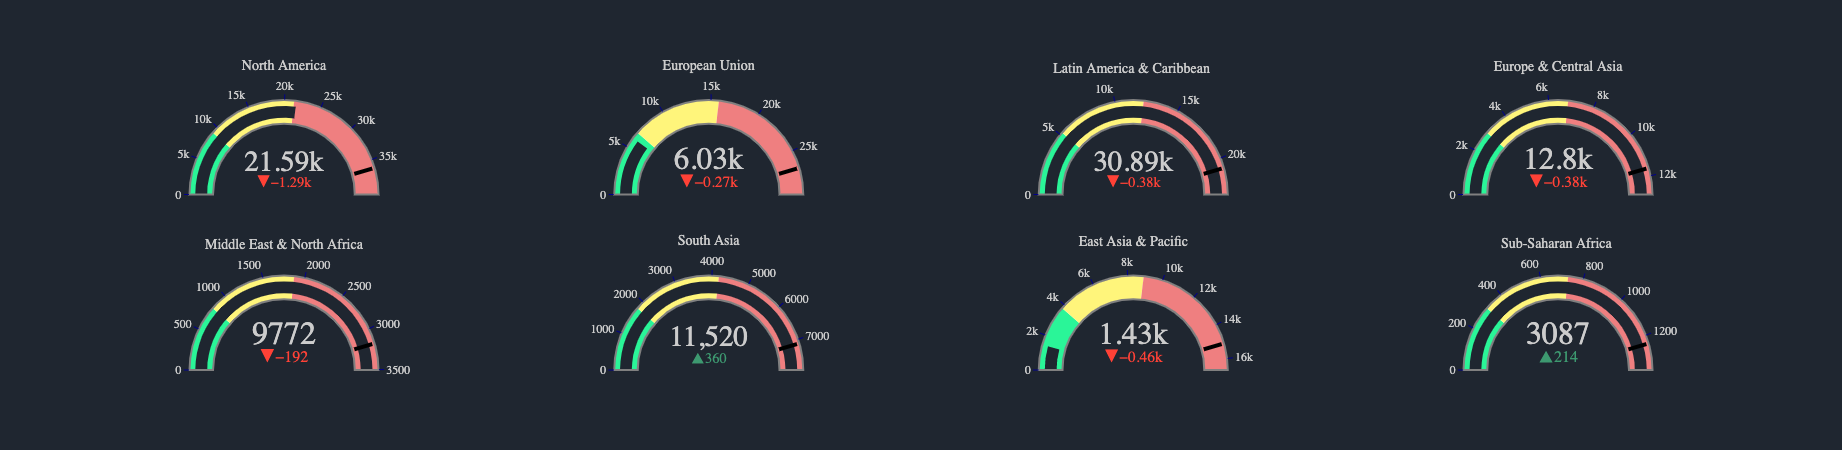

In [524]:
import plotly.graph_objects as go
from datetime import timedelta
from plotly.subplots import make_subplots


def add_gauge(fig, region, max_value, current_value, yd_value, position):
    
    range_1 = max_value/4
    range_2 = max_value/1.7
    
    fig.add_trace(go.Indicator(
                        mode = "number+gauge+delta",
                        gauge = {'axis': {'range': [0, max_value * 1.1], 'tickwidth': 1, 'tickcolor': "darkblue"},
                                 'bar': {'color': "#1f2630"},
                                 'bgcolor': "white",
                                 'borderwidth': 2,
                                 'bordercolor': "gray",
                                 'steps' : [
                                     {'range': [0, range_1], 'color': "#2AF598"},
                                     {'range': [range_1, range_2], 'color': "#FFF57B"},
                                     {'range': [range_2, max_value * 1.1], 'color': "#EF7F80"}],
                                      'threshold' : {'line': {'color': "black", 'width': 4}, 'thickness': 0.75, 'value': max_value}},
                        delta = {'reference': yd_value},
                        value = current_value,
                #         domain = {'x': [0, 1], 'y': [0.2, 0.9]},
                        title = {'text': f"{region}",'font': dict(size=14)}),
                row=position[0], col=position[1]
                 )
    return fig

def plot_regions(df, column):
    regions = len(df.region_wb.unique())
    
    plots = [{"type": 'indicator'} for i in range(8)]
    fig = make_subplots(rows=2, cols=4, 
                        specs=[plots[0:4], plots[4:]],
                        vertical_spacing=0.3,
                        horizontal_spacing=0.01,
#                         column_widths=[0.3, 0.7],
#                         row_heights=[0.5, 0.5],
                       )
    
    reg_df_sum_total = df_jh_world.groupby('region_wb').agg(['sum'])[column].sort_values(by='sum',ascending=False).round(0)
    
    reg_df_max = df.reset_index(drop=True).groupby(['date', 'region_wb']).agg(['max'])[column].groupby('region_wb').max()
    current_reg_df_sum = df.loc[df.index == df.index.max(), :].groupby('region_wb').agg(['sum'])[column].round(0)
    yd_reg_df_sum = df.loc[df.index == df.index.max() - timedelta(days=1), :].groupby('region_wb').agg(['sum'])[column].round(0)

    for i, region in enumerate(reg_df_sum_total.index.unique()):
        
        max_value = reg_df_max.reset_index().loc[reg_df_max.index == region, 'max'].values[0]
        current_value = current_reg_df_sum.reset_index().loc[current_reg_df_sum.index == region, 'sum'].values[0]
        yd_value = yd_reg_df_sum.reset_index().loc[yd_reg_df_sum.index == region, 'sum'].values[0]
        
        if i <= 3:
            position=[1, i+1]
        else:
            position=[2, i-4+1]
        fig = add_gauge(fig, region, max_value, current_value, yd_value, position)
    
    fig.update_layout(paper_bgcolor='#1f2630', font = {'color': "rgb(204, 204, 204)", 'family': "Garamond"})
    
    return fig

plot_regions(df_jh_world, 'confirmed_change').show()

In [437]:
plots = [{"type": 'indicator'} for i in range(8)]
    
fig = make_subplots(rows=2, cols=4, 
                specs=[plots[0:4], plots[4:]])
fig.print_grid()

This is the format of your plot grid:
[ (1,1)  ]  [ (1,2)  ]  [ (1,3)  ]  [ (1,4)  ]
[ (2,1)  ]  [ (2,2)  ]  [ (2,3)  ]  [ (2,4)  ]



In [ ]:
import plotly.graph_objects as go
from datetime import timedelta
from plotly.subplots import make_subplots


def add_gauge(fig, region, max_value, current_value, yd_value):
    
    range_1 = max_value/4
    range_2 = max_value/1.7
    
    trace = go.Indicator(
        mode = "number+gauge+delta",
        gauge = {'axis': {'range': [0, max_value * 1.1], 'tickwidth': 1, 'tickcolor': "darkblue"},
                 'bar': {'color': "darkblue"},
            'bgcolor': "white",
            'borderwidth': 2,
            'bordercolor': "gray",
                 'steps' : [
                     {'range': [0, range_1], 'color': "lightgray"},
                     {'range': [range_1, range_2], 'color': "gray"}],
                      'threshold' : {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': max_value}},
        delta = {'reference': yd_value},
        value = current_value,
        domain = {'x': [0, 1], 'y': [0.2, 0.9]},
        title = {'text': f"{region}"})
                
                 
    return trace

def plot_regions(df):
    regions = len(df.region_wb.unique())
    
    plots = [{"type": 'indicator'} for i in range(regions)]
    
    fig = make_subplots(rows=2, cols=4, 
#                     column_widths=[0.3, 0.7],
#                     row_heights=[0.5, 0.5],
                    specs=[plots[0:4], plots[4:]])
    
    for i, region in enumerate(df.region_wb.unique()):
        reg_df_max = df.reset_index(drop=True).groupby(['date', 'region_wb']).agg(['max'])[column].groupby('region_wb').max()
        max_value = reg_df_max.reset_index().loc[reg_df_max.index == region, 'max'].values[0]

        current_reg_df_sum = df.loc[df.index == df.index.max(), :].groupby('region_wb').agg(['sum'])[column].round(0)
        yd_reg_df_sum = df.loc[df.index == df.index.max() - timedelta(days=1), :].groupby('region_wb').agg(['sum'])[column].round(0)

        current_value = current_reg_df_sum.reset_index().loc[current_reg_df_sum.index == region, 'sum'].values[0]
        yd_value = yd_reg_df_sum.reset_index().loc[yd_reg_df_sum.index == region, 'sum'].values[0]
        
        fig.add_trace(add_gauge(fig, region, max_value, current_value, yd_value), row=np.floor(i/4)+1, col=i+1)
    
    return fig

# add_gauge(fig, reg_df, 'European Union').show()
plot_regions(df_jh_world).show()